## Sam Luby
## 13389446

# Part 1: Data Collection

The objective of this assignment and notebook is to perform web scraping, to gather the corpus of a number of articles from a webpage and its subpages and to evaluate the performance of some classification models on the corpus.


I use a number of functions to retrieve all the necessary data from the website, which has the baseurl:

In [1]:
baseurl = "http://mlg.ucd.ie/modules/COMP41680/archive/"

A number of modules are imported.

In [2]:
import os
from bs4 import BeautifulSoup as bs
import urllib
import re
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import *
import numpy as np
import matplotlib.pyplot as plt
import itertools

The __get_articles_list__ function is used to get a list of all the articles in all sub-pages of the website. It opens the website homepage and uses BeautifulSoup to parse the contents. It finds the subpages, and filters out the dead links at the bottom of the page by checking the length. Each subpage is added to a list. Then, for each 'monthly-subpage', I open the page and parse the contents, adding each valid article url to a list, which the function returns.

__get_category_labels__ is used to retreive the category labels for every article on the site, and store in a text file. It creates a text file and for each category in the monthly subpage if finds the category class in the <td> html tags. Each category found is added to the text file.

__get_article_contents__ opens each article url and reads the text contained in the file. This is achieved using the BeautifulSoup html parser. The article heading is contained in the 'h2' tag and the article contents are conained in the 'p' html paragraph tags. Only the relevant body of text is extracted, this is achieved by checking the 'p' html tag is empty.

__save_article_contents__ uses the get_article_contents function to retrieve the text contents of each article, and save the contents of each article into a seperate text file. Each filename is the sequential article number.

In [3]:
# get a list of all articles in all sub-pages of a website
def get_articles_list(baseurl):
    articles_list = list()
    months_list = list()

    # open url and get page contents
    f = urllib.request.urlopen(baseurl + "index.html")
    dat = f.read()
    page_contents = bs(dat, 'html.parser')

    # finds the links to sub-pages (monthly sub-page) on this index page (only legitimate links)
    for subpage in page_contents.find_all('a'):
        if len(subpage.get('href')) > 0:
            months_list.append(subpage.get('href'))

    # finds the links on the monthly sub-page which contains links to each article
    for i in range(len(months_list)):
        monthly_subpage = baseurl + months_list[i]
        f = urllib.request.urlopen(monthly_subpage)
        dat = f.read()
        monthly_contents = bs(dat, 'html.parser')

        # calls the get_category_labels function to add categories for each month to a file
        get_category_labels(monthly_contents)

        # get each link (each article) for the given month, append to list.
        for subpage in monthly_contents.find_all('a'):
            url = subpage.get('href')
            if "article" not in url:
                continue
            articles_list.append(url)
    return articles_list


# get the category labels for each month, store in text file
def get_category_labels(monthly_contents):
    # create directory for saving articles
    file = open("categories/categories.txt", "a")
    categories = ""

    # for the given monthly sub-page, put each article category into a file
    for category in monthly_contents.find_all('td', class_='category'):
        if "N/A" not in category.get_text():
            categories += category.get_text() + '\n'
    file.write(categories)
    file.close()


# gets the body of each article, by extracting plain text from <p> html tags
def get_article_content(article):

    # get each article url and open
    article_url = baseurl + article
    f = urllib.request.urlopen(article_url)
    dat = f.read()
    article_contents = bs(dat, 'html.parser')

    # get the content of each article, the text in each legitimate <h2> paragraph
    article_text = article_contents.find('h2').get_text()
    for paragraph in article_contents.find_all('p', class_=''):
        article_text += (paragraph.get_text() + "\n")
    return article_text


# save the contents of each article into a separate text file.
def save_article_contents(articles):

    # save the contents of each article into a seperate text file
    for i in range(len(articles)):
        article_text = get_article_content(articles[i])
        path = "data/" + "article_" + str(i) + ".txt"
        file = open(path, "w", encoding="utf-8")
        file.write(article_text)
        if i % 10 == 0:
            print('Saved article #' + str(i))
        file.close()

The __download_files__ function, below, is called which handles all data scraping. The function checks if the directory with files is already present, and skips the webscraping if so. This avoids downloading duplicates etc.
A directory is created for the article data and the categories for each article, and web scraping is them performed.

In [4]:
# only download  files if necessary
def download_files(baseurl):
    data_path = "data"
    categories_path = "categories"

    # check if directory exists, if not then download everything
    if not os.path.isdir(data_path):
        print("Files not present, downloading...")
        os.mkdir(data_path)
        os.mkdir(categories_path)
        articles_list = get_articles_list(baseurl)
        save_article_contents(articles_list)
    else:
        print("Files already present.")


download_files(baseurl) # main function for data scraping

Files already present.


# Part 2: Text Classification

## 1. Load Documents

In part one, I used BeautifulSoup to extract the title and body of each article and store them into seperate text files. I also saved the category of each article into a text file.

In this section, I load the categories into a list, as well as the filename of each article into a list. 

I also load the contents of each article into a list, and a list for each article's index for convenience. 

A pandas dataframe is created, where the columns are the article filename and article category. The filenames must be sorted using a technique called "natural sorting". This is because the filename is stored as as string, but contains an integer number (from 0 to 1407 for each article number). By not using natural sorting, the list of articles would be sorted incorrectly (article_0, article_1, article_10, article_100, article_1000) etc.


All of the above is achieved using five functions:

In [5]:
directory_category = "categories/categories.txt"
directory_articles = "data/"

# load each category from file
def load_categories(directory):
    with open(directory) as f:
        categories = [line.rstrip() for line in f]
    return categories


# load all filenames from subdirectory
def load_articles_filenames(directory):
    articles = []
    for file in os.listdir(directory):
        articles.append(file)
    return articles


# natural sorting for each article file name, which is type string
def natural_sorting(file):
    return [int(c) if c.isdigit() else c for c in re.split('(\d+)', file)]


# create pandas dataframe from categories and article filenames
def create_dataframe():
    categories = load_categories(directory_category)
    articles = load_articles_filenames(directory_articles)
    articles.sort(key=natural_sorting)
    df = pd.DataFrame({'CATEGORY': categories, 'ARTICLE': articles})
    return df


# load the contents (text) from each article
def load_all_articles_contents(number_of_articles):
    articles = list()
    articles_index = list()
    
    # for each article, append the contents and index to seperate lists
    for i in range(number_of_articles):
        file = open("data\\article_" + str(i) + ".txt", "r", encoding='utf-8')
        content = file.read()
        articles.append(content)
        articles_index.append(int(i))
    return articles, articles_index


The data is loaded into a dataframe:

In [6]:
df = create_dataframe()
print(len(df))

1408


## 2. Document-Term Matrix

The body of each article is 'tokenized'. Tokenizing is the process of dividing text into a series of tokens. The text is also 'lemmatized' to group together words based on their dictionar/base form or intended meaning. This is achieved in the __lemma_tokenizer__ function.


A document-term matrix is created, which is the frequency of words after tokenizing/lemmatizing. The articles are vectorized, excluding stop-words and using a filter to exclude words which have a document frequency less than 5. My custom tokenzier is used. The term matrix is created using the __create_term_matrix__ function.

In [7]:
# tokenizer and lemmatizer
def lemma_tokenizer(text):
    #tokenizer
    tokenize = CountVectorizer().build_tokenizer()
    tokens = tokenize(text)

    #lemmatisation
    lemmatizer = nltk.stem.WordNetLemmatizer()
    tokens_lemmatized = []
    for token in tokens:
        tokens_lemmatized.append(lemmatizer.lemmatize(token))
    return tokens_lemmatized


# document term-matrix (frequency of terms)
def create_term_matrix(articles):
    words = []
    for i in articles:
        lemma_tokens = lemma_tokenizer(i)
        words.extend(lemma_tokens)

    # create TF-IDF weighted document-term matrix
    vectorizer = TfidfVectorizer(min_df = 5, stop_words='english', tokenizer=lemma_tokenizer)
    term_matrix = vectorizer.fit_transform(articles)
    return term_matrix, vectorizer, words

Tokenization and lemmatization is used, and the document term matrix is created. The TF-IDF vectorizer is used to create the term matrix. The TF-IDF (or term frequency-inverse document frequency) has the advantage of weighting the words to reflect its importance in the article. Thus, terms that will appear in most if not all articles, like 'as' 'the' 'of' etc, are "weighed down" in the term frequency.

\begin{equation}
Term\ Frequency (TF) = \frac{Times\ a\ term\ appears\ in\ document}{Number\ of\ terms\ in\ document}
\end{equation}

\begin{equation}
Inverse\ Document\ Frequency = log\frac{Total\ number\ of\ documents}{Number\ of\ documents\ with\ term\ in\ it}
\end{equation}

In [8]:
articles, articles_index = load_all_articles_contents(len(df))
term_matrix, vectorizer, words = create_term_matrix(articles)

## 3. Classification Models

I chose to use three classificaiton models on the corpus. The three models chosen are the k-Nearest Neighbours Classifier, the Naive Bayes classifier and the Support Vector Machines model. 

Firstly, I isolate the categories column from the pandas dataframe. This column contains the categories of each of the 1408 articles and will be used for the classification models. 

In [9]:
target = df['CATEGORY']

The corpus is then split into training and test sets. I chose the test set size to be 20%. This is an appropriate ratio as this text processing is relatively low complexity, and choosing a high ratio would result in overfitting. 
The data is split up as follows:
1. data_train is the data to train the model.
2. data_test is the data used for evaluation.
3. target_train is the category labels to train the model.
4. target_test is the category labels used for evaluation.

In [10]:
data_train, data_test, target_train, target_test = train_test_split(term_matrix, target, test_size=0.2)

I then apply each of the three individual classifiers to the training data with the target category labels. 

The first classifier is the kNN - nearest neighbour. This classifier, in this case, predicts the article category based on the majority vote of its neighbours. If k=1, the decision is based on its nearest neighbour. The distance function metric used is the default parameter, that being the Minkowski metric. With the default power parameter of 2, this is equivalent to the Euclidean distance function. For the kNN classifier, I chose the number of nearest neighbours, k, to be 3.

\begin{equation}
    Euclidean\ Distance = \sqrt{\sum_{i=1}^{k}(x_i-y_i)^2}
\end{equation}


Next, I used the Naive Bayes model. This classifier, sometimes referred to as the 'idiot Bayes model', is often criticized due to its 'naive' assumption of the features being independent. 


Finally, I used the Support Vector Classifier/Machines model. The SVC used is linear, as without tuning the classifier only achieves an accuracy in the range of 35-40%. 

Precitions for the test data are made for each of the classification models, which will be used for evaluation purposes.

In [11]:
# kNN - Nearest Neighbour
model_kn = KNeighborsClassifier(n_neighbors=3)
model_kn.fit(data_train, target_train)
predicted_kn = model_kn.predict(data_test)


# Naive Bayes
model_nb = MultinomialNB()
model_nb.fit(data_train, target_train)
predicted_nb = model_nb.predict(data_test)


# Support Vector Machines
model_svc = SVC(kernel='linear')
model_svc.fit(data_train, target_train)
predicted_svc = model_svc.predict(data_test)

## 4. Evaluating Classification Models

### Accuracy
The first method I used to evaluate the three classification models is to calculate the accuracy. The accuracy is the fraction of correct predictions made by the classifier. 

\begin{equation}
Accuracy = \frac{Correct Predictions}{Total Predictions}
\end{equation}

In [12]:
# Accuracy
knn_acc = accuracy_score(target_test, predicted_kn)
nb_acc = accuracy_score(target_test, predicted_nb)
svc_acc = accuracy_score(target_test, predicted_svc)

print("Accuracy using kNN method: " + str(round(knn_acc*100, 2)) + "%")
print("Accuracy using Naive Bayes method: " + str(round(nb_acc*100, 2)) + "%")
print("Accuracy using SVM method: " + str(round(svc_acc*100, 2)) + "%")

Accuracy using kNN method: 95.39%
Accuracy using Naive Bayes method: 98.58%
Accuracy using SVM method: 98.94%


The results obtained by this evaluation method gave consistent results in the range 94-99%. Naive Bayes classification model often gave the best results, despite the fact it is a simple classifier and assumes independent features. 

### Cross-Validation Evaluation

The next technique I used to evaluate the predictive models is cross-validation.

Cross-validation involves parititioning the original data into distinct subsamples or 'folds', where each fold contains the same proportion of the corpus. The experiment is repeated for all folds and the accuracy is an average of each run.

I tested a range of different number of folds, to see if was any notable improvment in results. For _n_ folds, the __cross_val_score__ function returns _n_ accuracy scores, which can be averaged. I represent this as a percentage accuracy.

In [13]:
# Cross-Validation Evaluation
folds = [2, 3, 5, 10, 20]
for fold in folds:
    scores = cross_val_score(model_kn, term_matrix, target, cv=fold, scoring='accuracy')
    print("Evaluating kNN classifier with Cross-Validation (using " + str(fold) + " folds) yields avg score: " + str(round(scores.mean()*100, 2)) + "%")
    scores = cross_val_score(model_nb, term_matrix, target, cv=fold, scoring='accuracy')
    print("Evaluating NB  classifier with Cross-Validation (using " + str(fold) + " folds) yields avg score: "+ str(round(scores.mean()*100, 2)) + "%")
    scores = cross_val_score(model_svc, term_matrix, target, cv=fold, scoring='accuracy')
    print("Evaluating SVC classifier with Cross-Validation (using " + str(fold) + " folds) yields avg score: "+ str(round(scores.mean()*100, 2)) + "%\n")

Evaluating kNN classifier with Cross-Validation (using 2 folds) yields avg score: 95.88%
Evaluating NB  classifier with Cross-Validation (using 2 folds) yields avg score: 97.51%
Evaluating SVC classifier with Cross-Validation (using 2 folds) yields avg score: 97.58%

Evaluating kNN classifier with Cross-Validation (using 3 folds) yields avg score: 95.38%
Evaluating NB  classifier with Cross-Validation (using 3 folds) yields avg score: 97.94%
Evaluating SVC classifier with Cross-Validation (using 3 folds) yields avg score: 98.29%

Evaluating kNN classifier with Cross-Validation (using 5 folds) yields avg score: 95.46%
Evaluating NB  classifier with Cross-Validation (using 5 folds) yields avg score: 98.08%
Evaluating SVC classifier with Cross-Validation (using 5 folds) yields avg score: 98.37%

Evaluating kNN classifier with Cross-Validation (using 10 folds) yields avg score: 95.46%
Evaluating NB  classifier with Cross-Validation (using 10 folds) yields avg score: 98.01%
Evaluating SVC c

The cross-validation method of evaluating for the 3 different classifiers gives results in the range of approximately 95-99%. The support vector machines classifier seems to perform the best for this evaluation method.
The number of folds used appeared to have little to no affect on the accuracy results.

### Confusion Matrix Evaluation

The final method of classifier evaluation I used is a confusion matrix - also known as an error matrix. The confusion matrix is a way of visualising the performance of a classifier with a table layout. The table columns (in this case) represent the predicted categories and the rows are the true categories. 

In [14]:
# Confusion Matrix Evaluation
cm_knn = confusion_matrix(target_test, predicted_kn)
print("kNN Confusion Matrix" + '\n' +  str(cm_knn))
cm_nb = confusion_matrix(target_test, predicted_nb)
print("Naive Bayes Confusion Matrix" + '\n' +  str(cm_nb))
cm_svc = confusion_matrix(target_test, predicted_svc)
print("SVM Confusion Matrix" + '\n' +  str(cm_svc))

kNN Confusion Matrix
[[ 97   2   7]
 [  1 100   0]
 [  2   1  72]]
Naive Bayes Confusion Matrix
[[104   0   2]
 [  0 101   0]
 [  1   1  73]]
SVM Confusion Matrix
[[104   0   2]
 [  0 101   0]
 [  0   1  74]]


It can be seen from the matrices that performance of these models are all excellent by examining the values along the diagonal - known as the true values, which are the values for the true positives.



I used pyplot to create a confusion matrix table to more easily visualise the results. __Note__ that I repurposed some example code found on the scikit-learn.org website for these plots.  
http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

In [15]:
# plots the confusion matrix
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True category')
    plt.xlabel('Predicted category')
    
# gets the article categories (no duplicates)
def get_categories(df):
    categories = df[['CATEGORY']].drop_duplicates()['CATEGORY'].tolist()
    for i in  range(len(categories)):
        categories[i] = categories[i].replace(u'\xa0', '')
    return categories

I get the category names using my __get_categories__ function. This returns one of each category found in the categories file.

In [16]:
categories = get_categories(df)
categories

['technology', 'business', 'sport']

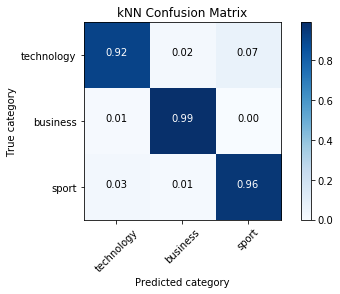

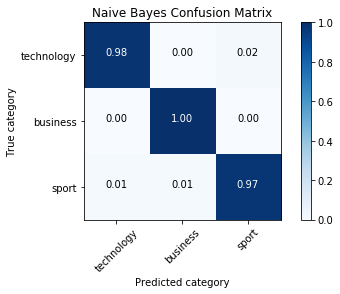

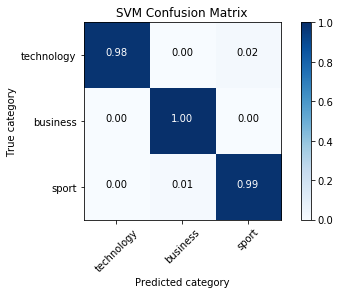

In [17]:
plt.figure()
plot_confusion_matrix(cm_knn, categories, title='kNN Confusion Matrix')
plt.figure()
plot_confusion_matrix(cm_nb, categories, title='Naive Bayes Confusion Matrix')
plt.figure()
plot_confusion_matrix(cm_svc, categories, title='SVM Confusion Matrix')
plt.show()

The above three plots show the performance of classifiers when evaluating using the confusion matrix. The values are normalised, reporting a ratiometric value of correct predictions to all predictions.

From examining the normalised plots obtained, and the non-normalised matrices above, it appears the kNN classifier performed the worst according to this method of evaluation.

# Conclusion

From the three methods of classifier evaluation used, it appears as though the Naive Bayes and SVM classifiers outperformed the kNN classifier.

Evaluating using the accuracy and cross-validation metrics revealed that the kNN classifier often scored 1-3% lower than the others. Additonally, in the normalised confusion matrix the kNN classifier has a higher rate of error comparatively. Some parameter tuning of the kNN classifier might reveal better results. 


The accuracy results obtained are very high, but after researching online I found that text classification is relatively simple compared to other forms of classification e.g. images etc. 

Additionally, the corpus contained only 3 labels, sports business & technology, which are quite different & distinguishable in their own right. Less distinct features might prove less accurate.



An article by Zakzouk and Mathkour, 'Comparing text classifiers for sports news' for the 'First World Conference on Innovation and Computer Sciences', concluded that the Naive Bayes model had the best effectiveness in terms of accuracy and processing time. [1]

Furthermore, a sutdy by Wang et al (2007) compared serveral text classification algorithms including Naive Bayes and SVM. Their conclusion found that once again, Naive Bayes performed the best. [2]

It is interesting to note that neither study used the kNN classifier, which may be for good reason.


[1] https://www.sciencedirect.com/science/article/pii/S2212017312001053

[2] https://www.researchgate.net/figure/Comparison-of-popular-text-classification-algorithms-The-performance-of-four-well-known_fig1_6182639